In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Info
In this notebook we will create a U-Net from scratch, train it on generating segmentation masks for breast cancer (benign or malignant).\
The notebok will be updated with Test and Validation loop implementations. \
The interesting aspect is the UNet architecture which allows to build any size of UNet without having to worry about dimension match or cropping the center image (as done within the paper). However, if you notice any shortcomings feel free to comment in order to improve it.

In [2]:
%%capture
!pip install -qqq segmentation-models-pytorch

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [5]:
import os
import glob
from tqdm import tqdm
import zipfile
import pandas as pd
import numpy as np
import re
from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

## 2. Functions

In [6]:
def load_image(image_path, mask_path=None, transform = ToTensorV2()):
    '''
    This function is used to transform images and masks using the same transformation, or individually images and masks
    '''
    
    numpy_img = np.array(Image.open(image_path))
    masks = [np.array(Image.open(mask).convert("L"), dtype=np.float32) for mask in mask_path] if mask_path else None
    if mask_path:
        if len(mask_path) == 1:
            aug = transform(image=numpy_img, mask=masks[0])
            state=True # There are 1 or less masks
        else:
            aug = transform(image=numpy_img, masks=masks)
            state=False # There are multiple masks
    else:
        aug = transform(image=numpy_img)
        state=False
    return aug, state

In [7]:
def show_images(unique_id: str, mask: str=False, alpha: int=0.3, transform = ToTensorV2()):
    '''
    This function is used to print the transformed image and masks if available (overlay)
    '''
    temp_df = df.loc[df['unique_id'] == unique_id].reset_index(drop=True) # df is defined outside the function
    img_path = list(temp_df.loc[temp_df['mask'] == False, 'path'].reset_index(drop=True))
    mask_path = list(temp_df.loc[temp_df['mask'] == True, 'path'].reset_index(drop=True))

    aug, state = load_image(img_path[0], mask_path, transform)

    plt.imshow(aug['image'].permute(1,2,0))
    plt.show()
    if mask:
        plt.imshow(aug['image'].permute(1,2,0))
        if state:
            plt.imshow(aug['mask'], alpha=alpha)
        else:
            for m in aug['masks']:
                plt.imshow(m, alpha=alpha)

In [8]:
# def dice_coef_metric(original_masks, predicted_masks, threshold=0.5):
#     total_dice = []
#     for i in range(original_masks.shape[0]):
#         original_mask = torch.squeeze(original_masks[i]).detach().cpu().numpy()
#         predicted_mask = torch.nn.functional.sigmoid(torch.squeeze(predicted_masks[i])).detach().cpu().numpy()
        
#         bnr_pred_mask = (predicted_mask<threshold)+0

#         intersection_region = np.sum(original_mask*bnr_pred_mask)
#         individual_sums = np.sum(original_mask) + np.sum(bnr_pred_mask)
#         dice_coef = 2*intersection_region/individual_sums
        
#         total_dice.append(dice_coef)

#     return np.mean(total_dice)

In [9]:
# def iou_metric(original_masks, predicted_masks, threshold=0.5):
#     total_iou = []
#     for i in range(original_masks.shape[0]):
#         original_mask = torch.squeeze(original_masks[i]).detach().cpu().numpy()
#         predicted_mask = torch.nn.functional.sigmoid(torch.squeeze(predicted_masks[i])).detach().cpu().numpy()
        
#         bnr_pred_mask = (predicted_mask<threshold)+0

#         intersection_region = np.sum(original_mask*bnr_pred_mask)
#         union = np.sum(original_mask) + np.sum(bnr_pred_mask) - intersection_region
#         iou_coef = 2*intersection_region/union
        
#         total_iou.append(iou_coef)
    
#     return np.mean(total_iou)

## 3. Datasets

### 3.1 Extract Data

In [10]:
data_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
labels_path = [os.path.join(data_path, p) for p in os.listdir(data_path)]

In [11]:
df_dict = {'path':[]}

for label_path in labels_path:
    df_dict['path'] += [os.path.join(label_path, img) for img in glob.glob(os.path.join(label_path, '*.png'))]
    
df = pd.DataFrame(df_dict)

In [12]:
df['label'] = df['path'].apply(lambda x: x.split('/')[-1].split('(')[0].strip())
df['num'] = df['path'].apply(lambda x: int(re.findall(r'\((.*?)\)', x.split('/')[-1])[0]))
df['mask'] = df['path'].apply(lambda x: True if 'mask' in x else False)
df['unique_id'] = df['path'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[0].strip())

In [13]:
df.head()

,path,label,num,mask,unique_id
0,/kaggle/input/breast-ultrasound-images-dataset...,benign,2,False,benign (2)
1,/kaggle/input/breast-ultrasound-images-dataset...,benign,285,False,benign (285)
2,/kaggle/input/breast-ultrasound-images-dataset...,benign,166,True,benign (166)
3,/kaggle/input/breast-ultrasound-images-dataset...,benign,290,True,benign (290)
4,/kaggle/input/breast-ultrasound-images-dataset...,benign,300,False,benign (300)


#### 3.2 Visualise some data

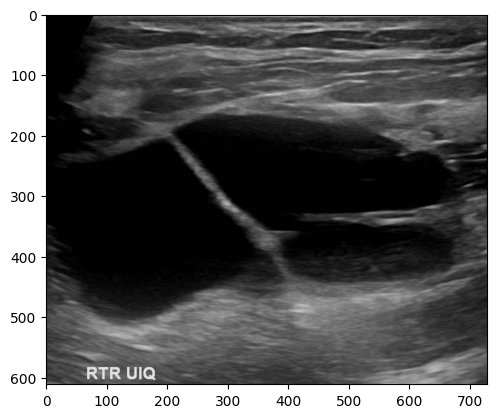

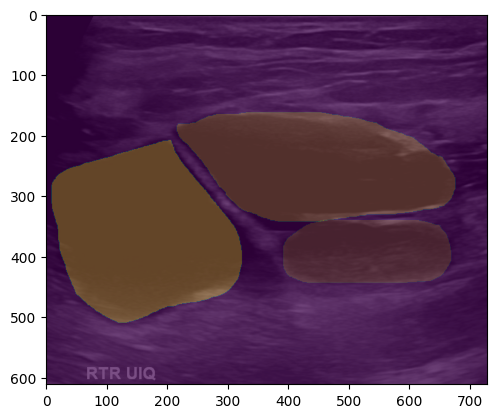

In [14]:
show_images('benign (195)', mask=True) # no transformation

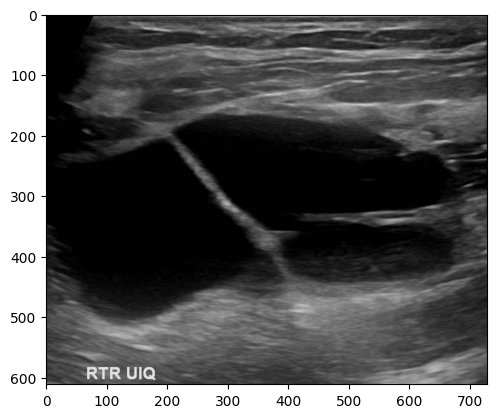

In [15]:
show_images('benign (195)', mask=False) # no transformation

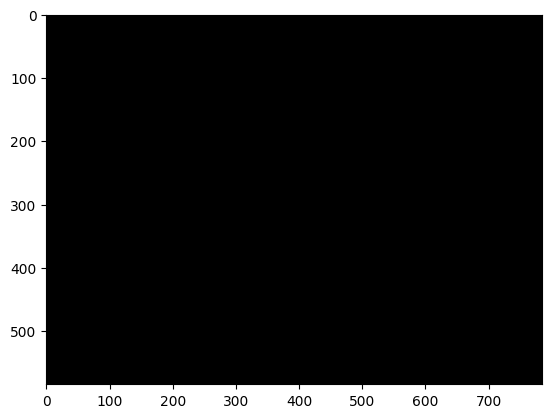

In [16]:
# visualising a single mask image
masks = df.loc[df['mask'], :].reset_index(drop=True)
paths = masks.loc[masks['unique_id']=='normal (116)', 'path'].tolist()
img = Image.open(paths[0]).convert('RGB')
numpy_img = np.array(img).astype(np.uint8)
transform = ToTensorV2()
mask_image = transform(image = numpy_img)
plt.imshow(mask_image['image'].permute(1,2,0))
plt.show()

#### 3.3 Split Train-Test-Validate (Only cancerous)

In [17]:
# normal_ids = list(df.loc[df['label']=='normal', 'unique_id'].unique())
# benign_ids = list(df.loc[df['label']=='benign', 'unique_id'].unique())
# malignant_ids = list(df.loc[df['label']=='malignant', 'unique_id'].unique())
cancer_ids = list(df.loc[df['label'] != 'normal', 'unique_id'].unique())

In [18]:
# print('Normal entries: {}'.format(len(normal_ids)))
print('Cancer entries: {}'.format(len(cancer_ids)))

Cancer entries: 647


In [19]:
# train_normal, ttest_normal = train_test_split(normal_ids, test_size=0.2)
# test_normal, val_normal = train_test_split(ttest_normal, test_size=0.5)

# train_benign, ttest_benign = train_test_split(benign_ids, test_size=0.2)
# test_benign, val_benign = train_test_split(ttest_benign, test_size=0.5)

# train_malignant, ttest_malignant = train_test_split(malignant_ids, test_size=0.2)
# test_malignant, val_malignant = train_test_split(ttest_malignant, test_size=0.5)

train_cancer, ttest_cancer = train_test_split(cancer_ids, test_size=0.2)
test_cancer, val_cancer = train_test_split(ttest_cancer, test_size=0.5)

In [20]:
# train_id = train_normal + train_benign + train_malignant
# test_id = test_normal + test_benign + test_malignant
# val_id = val_normal + val_benign + val_malignant

train_id = train_cancer
test_id = test_cancer
val_id = val_cancer

In [21]:
train_df = df.loc[df['unique_id'].isin(train_id), :].reset_index(drop=True)
test_df = df.loc[df['unique_id'].isin(test_id), :].reset_index(drop=True)
val_df = df.loc[df['unique_id'].isin(val_id), :].reset_index(drop=True)

In [22]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)
val_df.to_csv('val.csv', index=False)

In [23]:
print('Training dataset: {}'.format(train_df.shape[0]))
print('Testing dataset: {}'.format(test_df.shape[0]))
print('Validation dataset: {}'.format(val_df.shape[0]))

Training dataset: 1047
Testing dataset: 134
Validation dataset: 131


#### 3.4 Study image dimension

In [24]:
images_dim = [Image.open(df.loc[(df['unique_id']==image) & (df['mask']==True), 'path'].values[0]).size for image in cancer_ids]

In [25]:
print('Mean image dimensions: {}'.format(np.mean(images_dim, axis=(0))))
print('Mean value of the above dimensions: {}'.format(np.mean(np.mean(images_dim, axis=(0)))))

Mean image dimensions: [608.38330757 494.9984544 ]
Mean value of the above dimensions: 551.6908809891809


#### 3.5 Transformation



In [26]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
# LEARNING_RATE = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ]
    )

In [28]:
val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

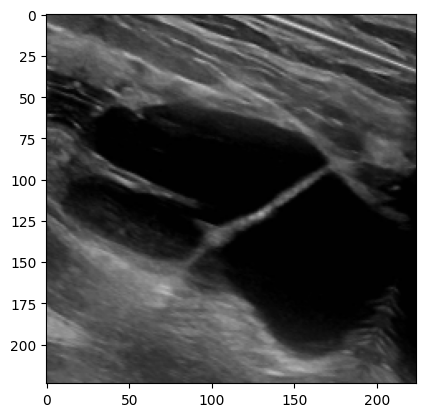

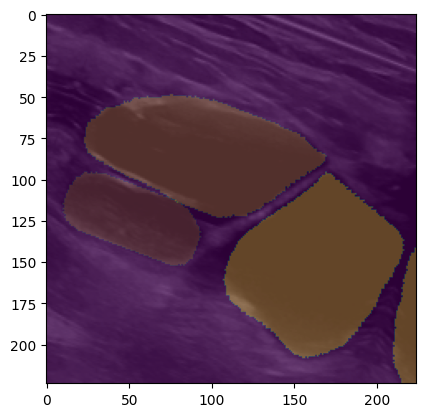

In [29]:
show_images('benign (195)', mask=True, transform=train_transform)

In [30]:
temp_df = df.loc[df['unique_id']=='benign (195)', :].reset_index()
image = list(temp_df.loc[temp_df['mask']==False, 'path'])
mask = list(temp_df.loc[temp_df['mask']==True, 'path'])

In [31]:
aug, _ = load_image(image[0], mask, train_transform)
print(aug.keys())
print('Masks for this image: {}'.format(len(aug['masks'])))

dict_keys(['image', 'masks'])
Masks for this image: 3


#### 3.6 Dataset and Dataloader

In [32]:
class unetDataset(Dataset):
    def __init__(self, csv_path, transform):
        self.df = pd.read_csv(csv_path)
        self.ids = self.df['unique_id'].unique()
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        selected_id = self.ids[index]
        
#         selected_id = 'benign (173)'
        temp_df = self.df.loc[self.df['unique_id']==selected_id, :]

        img_path = list(temp_df.loc[temp_df['mask']==False, 'path'])
        mask_path = list(temp_df.loc[temp_df['mask']==True, 'path'])
        
        aug, _ = load_image(img_path[0], mask_path, self.transform)

        masks = torch.stack(aug['masks'], dim=0) if 'masks' in aug.keys() else torch.unsqueeze(aug['mask'], 0)
        final_mask = torch.sum(masks, dim=0) # merging the masks into a single mask
        return aug['image'], torch.unsqueeze(final_mask, 0)/255

#### 3.7 Sample image

In [33]:
train_dataset = unetDataset('/kaggle/working/train.csv', train_transform)

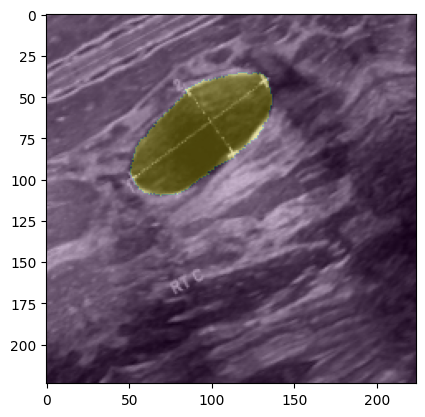

In [34]:
x, y = train_dataset.__getitem__(100)
plt.imshow(x.permute(1,2,0))
plt.imshow(y[0], alpha=0.3)

#### 3.8 Create dataset and dataloaders

In [35]:
train_dataset = unetDataset('/kaggle/working/train.csv', train_transform)
val_dataset = unetDataset('/kaggle/working/val.csv', val_transform)
test_dataset = unetDataset('/kaggle/working/test.csv', val_transform)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

## 4. Model Architecture

In [37]:
class customUNet(nn.Module):
    def __init__(self, 
                 image_shape = [572, 572], 
                 input_channels: int=1, 
                 output_channels: int=2, 
                 feature_channels: list = [64, 128, 256, 512, 1024], 
                 conv_kernel=(3, 3),
                 conv_pad='same', 
                 conv_stride=1, 
                 maxpool_kernel=(2, 2), 
                 maxpool_pad=0, 
                 maxpool_stride=2, 
                 trans_conv_kernel=(2, 2),
                 trans_conv_pad=0, 
                 trans_conv_stride=2, ):
        
        super().__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size = maxpool_kernel, 
                                    stride = maxpool_stride, 
                                    padding = maxpool_pad)
        
        # Downsampling
        self.down_sample_outputs = nn.ModuleList()
        prev_num_channel = input_channels
        for down_cnn in feature_channels:
            self.down_sample_outputs.append(nn.Sequential(nn.Conv2d(prev_num_channel, 
                                                                    down_cnn, 
                                                                    kernel_size=conv_kernel, 
                                                                    stride= conv_stride, 
                                                                    padding = conv_pad),
                                                          nn.ReLU(inplace=True),
                                                          nn.BatchNorm2d(num_features=down_cnn),
                                                          nn.Conv2d(down_cnn, 
                                                                    down_cnn, 
                                                                    kernel_size=conv_kernel, 
                                                                    stride= conv_stride, 
                                                                    padding = conv_pad), 
                                                          nn.ReLU(inplace=True), 
                                                          nn.BatchNorm2d(num_features=down_cnn)),
                                           )
            prev_num_channel = down_cnn
            
            
        # Upsampling
        self.up_sample_outputs = nn.ModuleList()
        for up_cnn in feature_channels[::-1][1:]:
            self.up_sample_outputs.append(nn.ConvTranspose2d(prev_num_channel,
                                                             up_cnn,
                                                             kernel_size=trans_conv_kernel,
                                                             stride= trans_conv_stride,
                                                             padding = trans_conv_pad))
            
            self.up_sample_outputs.append(nn.Sequential(nn.Conv2d(prev_num_channel, 
                                                                  up_cnn, 
                                                                  kernel_size=conv_kernel,
                                                                  stride= conv_stride, 
                                                                  padding = conv_pad),
                                                         nn.ReLU(inplace=True),
                                                        nn.BatchNorm2d(num_features=up_cnn),
                                                         nn.Conv2d(up_cnn, 
                                                                   up_cnn, 
                                                                   kernel_size=conv_kernel,
                                                                   stride= conv_stride, 
                                                                   padding = conv_pad), 
                                                         nn.ReLU(inplace=True), 
                                                        nn.BatchNorm2d(num_features=up_cnn))
                                         )
                                        
            prev_num_channel = up_cnn
            
        # output layer                               
        self.final_cnn = nn.Conv2d(prev_num_channel, output_channels, kernel_size=(1, 1))
        
        # downsample dimension
        self.down_samp_dims = []
        output_feature_size = image_shape[0] # assuming square images
        for i in range(len(feature_channels)):
            # Double convolution
            for j in range(2):
                if conv_pad == 'same':
                    output_feature_size = output_feature_size
                else:
                    output_feature_size = (output_feature_size + 2*conv_pad - conv_kernel[0])//conv_stride + 1
            self.down_samp_dims.append(output_feature_size)
            output_feature_size = (output_feature_size + 2*maxpool_pad - maxpool_kernel[0])//maxpool_stride + 1
        self.down_samp_dims # feature maps dimension when downsampling
                
        # upsample dimension
        self.up_samp_dims = []
        output_feature_size = self.down_samp_dims[-1]
        for i in range(len(self.down_samp_dims)):
            # Deconvolution
            if trans_conv_pad == 'same': 
                output_feature_size=output_feature_size
            else:
                output_feature_size = (output_feature_size-1)*trans_conv_stride - (2*trans_conv_pad) + (1 * (trans_conv_kernel[0]-1)) + 0 + 1
            self.up_samp_dims.append(output_feature_size)
            
            # Double convolution
            for j in range(2):
                if conv_pad == 'same':
                    output_feature_size=output_feature_size
                else:
                    output_feature_size = (output_feature_size + 2*conv_pad - conv_kernel[0])//conv_stride + 1
        
        self.down_samp_dims.pop(-1)
        self.up_samp_dims.pop(-1) # feature maps dimension when upsampling (except last one)
        
        self.down_samp_dims.reverse()
        
    def forward(self, x):
        
        down_outputs = []
        for layer in self.down_sample_outputs:
            x = layer(x)
            down_outputs.append(x)
            x = self.maxpool(x)
        
        x = down_outputs[-1] # we dont need the maxpool generate for the last layer
        
        down_outputs.pop(-1)
        down_outputs.reverse()
        for counter, torch_modules in enumerate(zip(self.up_sample_outputs[::2], self.up_sample_outputs[1::2])):
            tr_conv = torch_modules[0]
            seq_module = torch_modules[1]
            
            x = tr_conv(x) # output from deconvolution
            
            up_dim = self.down_samp_dims[counter]
            down_dim = self.up_samp_dims[counter]
                        
            bl = [(up_dim-down_dim)//2, (up_dim-down_dim)//2]
            tr = [bl[0]+down_dim, bl[1]+down_dim]
            
            down_sample_feature_output = down_outputs[counter][:, :, bl[0]:tr[0], bl[1]:tr[1]]
            
            x = torch.concat([down_sample_feature_output, x], dim=1)
            
            x = seq_module(x)
        
        x = self.final_cnn(x)
        
        return x

## 5. Train
The training loop is inspired by the HEISWICKED's notebook (https://www.kaggle.com/code/heiswicked/pytorch-unet-segmentation-tumour#notebook-container) because of the use of the segmentation-models-pytorch library which allowed for a better loss function and better track of metrics

In [38]:
# def train(model, device, loader, loss_fn, optimizer, grad=True):
#     total_loss = [] # step loss
#     total_dice_metric = [] # step dice coefficient
#     total_iou_metric = [] # step IOU coefficient
    
#     for batch, (image, masks) in enumerate(tqdm(loader)):
#         image = image.to(device)
#         masks = masks.float().to(device)
        
#         dim = masks.shape[-1]//2 # 572//2
#         des_dim = 224 # output shape
#         dim -= des_dim//2
#         crop_image = torchvision.transforms.functional.crop(masks, dim, dim, des_dim, des_dim) # Crop the original mask
        
#         # forward
#         # allows to run in mixed precision
#         optimizer.zero_grad() # zeroe the gradient from prior run
        
# #         with torch.cuda.amp.autocast():
# #             predictions = model(image)
# #             loss = loss_fn(predictions, crop_image)
# #             dice_metric_val = dice_coef_metric(masks, predictions, 0.6)
# #             iou_metric_val = iou_metric(masks, predictions, 0.6)     
#         predictions = model(image)
#         loss = loss_fn(predictions, crop_image)
#         dice_metric_val = dice_coef_metric(masks, predictions, 0.6)
#         iou_metric_val = iou_metric(masks, predictions, 0.6)     
        
#         loss.backward()
#         optimizer.step()
        
#         total_loss.append(loss.detach().cpu().numpy())
#         total_dice_metric.append(dice_metric_val)
#         total_iou_metric.append(iou_metric_val)
            
#     print('Average loss: {}'.format(np.mean(total_loss)))
#     print('Average DICE: {}'.format(np.mean(total_dice_metric)))
#     print('Average IOU: {}'.format(np.mean(total_iou_metric)))
    
#     return total_loss, total_dice_metric, total_iou_metric

In [39]:
def train(model, device, loader, loss_fn, optimizer, grad=True):
    train_loss, dataset_size = 0,  0
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    for batch, (image, masks) in enumerate(tqdm(loader)):
        image = image.to(device)
        masks = masks.float().to(device)
        
        dim = masks.shape[-1]//2 # 572//2
        des_dim = 224 # output shape
        dim -= des_dim//2
        # forward
        # allows to run in mixed precision
   
        predictions = model(image)
        loss = loss_fn(predictions, masks)
        pred_mask = (predictions > 0.5).float()
        btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), masks.long(), mode="binary")
        
        optimizer.zero_grad() # zeroe the gradient from prior run
        loss.backward()
        optimizer.step()
                
        bs = image.shape[0]
        dataset_size += bs
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size
        
        tp_l.append(btp)
        fp_l.append(bfp)
        fn_l.append(bfn)
        tn_l.append(btn)
        
        tp = torch.cat(tp_l)
        fp = torch.cat(fp_l)
        fn = torch.cat(fn_l)
        tn = torch.cat(tn_l)
        
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

#         bar.set_description(f"EP:{epoch} | TL:{train_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")
        
    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = train_epoch_loss

    return metrics

    
    return total_loss, total_dice_metric, total_iou_metric

## 6. Define and Train the model

In [40]:
model = customUNet(image_shape = [224, 224], 
                   feature_channels = [4, 8, 16, 32, 64],
                   input_channels=3, 
                   output_channels=1)
model.to(device)
print('Model is loaded!')

Model is loaded!


In [41]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
LEARNING_RATE = 1e-2

In [42]:
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [43]:
EPOCHS = 30
losses = []
dices = []
ious = []

In [44]:
train_history = []
train_recalls = []

train_pres = []
train_accs = []

train_f1s = []

train_per_ious = []
train_dataset_ious = []


for epoch in range(EPOCHS):
    model.train()
    train_metrics  = train(model, device, train_loader, loss_fn, optimizer, grad=True)
    
    
    # 줍줍 : Joob-Joob, which means 'get-get'
    train_history += [train_metrics['loss']]

    train_recalls += [train_metrics['recall']]

    train_pres += [train_metrics['precision']]

    train_accs += [train_metrics['accuracy']]

    train_f1s += [train_metrics['f1_score']]

    train_per_ious += [train_metrics['per_iou']]

    train_dataset_ious += [train_metrics['dataset_iou']]


100%|██████████| 32/32 [00:31<00:00,  1.02it/s]


## 7. Plots of the different metrics

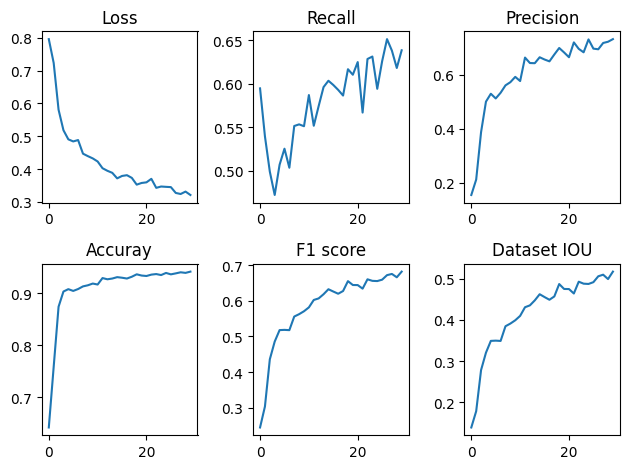

In [45]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(train_history)
axs[0, 0].set_title('Loss')

axs[0, 1].plot(train_recalls)
axs[0, 1].set_title('Recall')

axs[0, 2].plot(train_pres)
axs[0, 2].set_title('Precision')

axs[1, 0].plot(train_accs)
axs[1, 0].set_title('Accuray')

axs[1, 1].plot(train_f1s)
axs[1, 1].set_title('F1 score')

axs[1, 2].plot(train_dataset_ious)
axs[1, 2].set_title('Dataset IOU')


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

## 8. Test the model

In [46]:
model.eval()
print('Done')

Done


In [47]:
x, y = next(iter(train_loader))
z = model(x.to(device))

Ground Truth


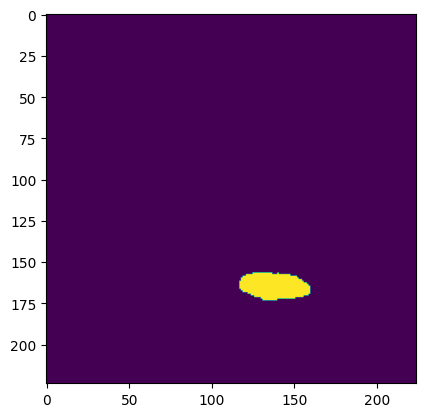

In [48]:
print('Ground Truth')
plt.imshow(y[0, 0])
plt.show()

Prediction


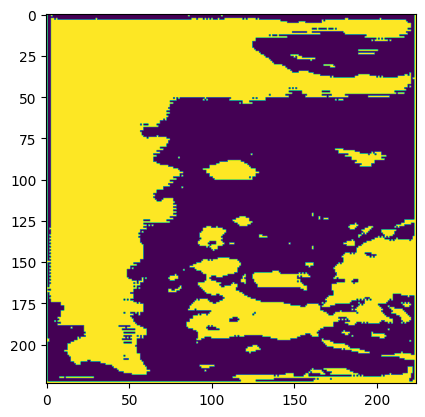

In [49]:
print('Prediction')
temp_mean = np.mean(z[0, 0].detach().cpu().numpy())
# print(temp_mean)
plt.imshow((z[0, 0].detach().cpu().numpy()>temp_mean)+0)
plt.show()

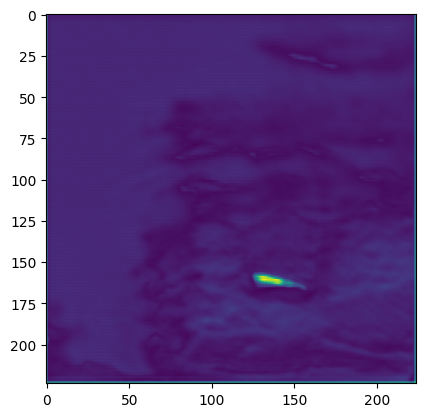

In [50]:
plt.imshow(z[0, 0].detach().cpu().numpy())
plt.show()